# Propensity Modelling

## Modelling to identify customers who might take up or buy a specific product
### Contact the right customers with the right offer to the right channel at the right time


Vodacom launced the digital contents initiative in Septemter 2017. The service amongst others include the ability to buy applications from sevices like Google Play and having the option to pay with airtime or get billed to your Vodacom contract.

The benefit to Vodacom is two-fold. There is a shared revenue agreement with the different service providers and as a result of purchasing and downlaoding apps data usage also increases.

Since its inception the digitial contents intiative has not used any advanced machine learning in or intelligent campaigns in order to target and expand this product offering and marketing this to new customers.

The purpose of this study is to determine if we are able to use machine learning and 3 months worth of historical data to train a model that will be able to predict and identify new customers to which Vodacom can expand and market the digital contents offering.

The scope of this project is focused on the Google Play service since that is where the most potential revenue lies. This can always be expanded to the other 8 digital channels like Netflix for example.


In [2]:
## Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns; sns.set()
from sklearn.preprocessing import StandardScaler


In [693]:
#df= pd.read_csv("digital_content_services.csv")

df = pd.read_csv("/Users/dgitahi/documents/github/Propensity-Model/digital_content_services.csv")

In [694]:
df.head()

,EVENT_MONTH,MSISDN,MANUFACTURER,MODEL,OPERATING_SYSTEM,SERVICE_PROVIDER_ID,SERVICE_NAME,CONTENT_DESCRIPTION,REQUEST_TYPE,TRANSACTION_STATUS,...,CONNECTED_DAYS,CONNECTED_YEARS,PAYMENT_METHOD,CNT_DIGITAL_TRANSACTIONS,TOTAL_VOL_MB,CNT_ACTV_DATA_DAYS,AMOUNT_EXCL_VAT,CNT_ACTV_VOICE_DAYS,EVENT_DURATION_SEC,EVENT_DUR_MIN
0,May-18,C6034E1834450E,Samsung,Galaxy J1 ACE SM-J111F,ANDROID,GooglePlay,Google Play Application,Google Play Application,DEBIT,ACCEPTED,...,444,1.22,P,1.0,718.61938,31,0.00,30.0,25168.0,419.47
1,Aug-18,C6034D0909591F,Samsung,SM-N9005 Galaxy Note 3 LTE,ANDROID,DCB SGN,GameMine,GameMine,DEBIT,UNKNOWN,...,159,0.44,P,1.0,2405.75596,8,10.44,14.0,7554.0,125.90
2,Aug-18,C6034D0A252019,Vodafone,Vodafone Smart ultra 7,ANDROID,GooglePlay,Google Play Application,Google Play Application,DEBIT,ACCEPTED,...,1231,3.37,P,1.0,1672.35587,17,0.00,28.0,9722.0,162.03
3,May-18,C6034E1C281C03,Vodafone,Vodafone Smart mini 7,ANDROID,GooglePlay,Google Play Application,Google Play Application,DEBIT,ACCEPTED,...,630,1.73,P,6.0,1135.98838,31,0.00,31.0,6444.0,107.40
4,Aug-18,C6034E3E305B0D,Samsung Korea,GALAXY GRAND PRIME,ANDROID,GooglePlay,Google Play Application,Google Play Application,DEBIT,ACCEPTED,...,388,1.06,P,1.0,0.02314,1,0.00,3.0,72.0,1.20


In [695]:
df.columns

Index(['EVENT_MONTH', 'MSISDN', 'MANUFACTURER', 'MODEL', 'OPERATING_SYSTEM',
       'SERVICE_PROVIDER_ID', 'SERVICE_NAME', 'CONTENT_DESCRIPTION',
       'REQUEST_TYPE', 'TRANSACTION_STATUS', 'ENGAGED', 'SUBSCRIBER_STATUS',
       'CONNECTED_DAYS', 'CONNECTED_YEARS', 'PAYMENT_METHOD',
       'CNT_DIGITAL_TRANSACTIONS', 'TOTAL_VOL_MB', 'CNT_ACTV_DATA_DAYS',
       'AMOUNT_EXCL_VAT', 'CNT_ACTV_VOICE_DAYS', 'EVENT_DURATION_SEC',
       'EVENT_DUR_MIN'],
      dtype='object')

In [696]:
df.duplicated(subset=None, keep='first').sum()

0

Drop any customer who has more than 30 days for the Active days per Month

In [697]:
df =df[df.CNT_ACTV_VOICE_DAYS<=31]

df =df[df.TOTAL_VOL_MB<=50000]

Since  Service Provider ID ,Service_Name and Content Description have similar information we can drop two and be left with one

In [698]:
df.drop("SERVICE_PROVIDER_ID",axis= 1,inplace = True)
df.drop("SERVICE_NAME",axis= 1,inplace = True)

In [699]:
df.groupby(by= "CONTENT_DESCRIPTION")["EVENT_MONTH"].count()

CONTENT_DESCRIPTION
Apple Store                   29
GameMine                    4104
Google Play Application    33861
Video Play                    17
Vodacom                     9362
Name: EVENT_MONTH, dtype: int64

#### Checking and Replacing the Nulls

In [700]:
df.isnull().sum()

EVENT_MONTH                      0
MSISDN                           0
MANUFACTURER                     0
MODEL                            0
OPERATING_SYSTEM                 0
CONTENT_DESCRIPTION         307199
REQUEST_TYPE                307199
TRANSACTION_STATUS          307199
ENGAGED                          0
SUBSCRIBER_STATUS                0
CONNECTED_DAYS                   0
CONNECTED_YEARS                  0
PAYMENT_METHOD                  70
CNT_DIGITAL_TRANSACTIONS    307199
TOTAL_VOL_MB                     0
CNT_ACTV_DATA_DAYS               0
AMOUNT_EXCL_VAT             307199
CNT_ACTV_VOICE_DAYS              0
EVENT_DURATION_SEC               0
EVENT_DUR_MIN                    0
dtype: int64

The nulls in the Content_description are for the customers who have not bought the digital content. Therefore we will replace them with an abitrary string

In [701]:
df= df.fillna(value ={"CONTENT_DESCRIPTION":"Not_Bought","REQUEST_TYPE":"Not_Bought",
                      "TRANSACTION_STATUS":"Not_Bought","CNT_DIGITAL_TRANSACTIONS":"Not_Bought" },inplace = True)
                                                                       

For the count of Digital Transactions and Amount Exclusive of VAT we fill the NAs with zero because those customers have not used the Digital services.

In [702]:
df= df.fillna(value ={"CNT_ACTV_VOICE_DAYS":0,"AMOUNT_EXCL_VAT":0,
                      "EVENT_DUR_MIN":0, "EVENT_DURATION_SEC":0},inplace=True)

The most common method of Payment is P(prepaid). We replace the 71 missing value with P

In [703]:
df.groupby(by ="PAYMENT_METHOD")["PAYMENT_METHOD"].count()

PAYMENT_METHOD
C     17362
M     56905
P    280235
Name: PAYMENT_METHOD, dtype: int64

In [704]:
df = df.fillna(value = {"PAYMENT_METHOD":"P"},inplace = True)

In [705]:
df[df.isnull().any(axis=1)]

,EVENT_MONTH,MSISDN,MANUFACTURER,MODEL,OPERATING_SYSTEM,CONTENT_DESCRIPTION,REQUEST_TYPE,TRANSACTION_STATUS,ENGAGED,SUBSCRIBER_STATUS,CONNECTED_DAYS,CONNECTED_YEARS,PAYMENT_METHOD,CNT_DIGITAL_TRANSACTIONS,TOTAL_VOL_MB,CNT_ACTV_DATA_DAYS,AMOUNT_EXCL_VAT,CNT_ACTV_VOICE_DAYS,EVENT_DURATION_SEC,EVENT_DUR_MIN


In [706]:
df["CNT_ACTV_VOICE_DAYS"].quantile((0,0.25,0.5,0.75,0.90))

0.00     1.0
0.25    13.0
0.50    27.0
0.75    30.0
0.90    31.0
Name: CNT_ACTV_VOICE_DAYS, dtype: float64

In [707]:
df =  df.fillna(value= {"CNT_ACTV_DAYS":0,"TOTAL_VOICE_DURATION":0},inplace = True)

In [708]:
df.groupby(by ="CONTENT_DESCRIPTION")["CONTENT_DESCRIPTION"].count()

CONTENT_DESCRIPTION
Apple Store                    29
GameMine                     4104
Google Play Application     33861
Not_Bought                 307199
Video Play                     17
Vodacom                      9362
Name: CONTENT_DESCRIPTION, dtype: int64

Filter the data with Google Play Application content and those who did not buy any content

In [709]:
content = ["Google Play Application", "Not_Bought"]

#gapminder_Ocean = gapminder[~gapminder.continent.isin(continents)]
df2 = df[df.CONTENT_DESCRIPTION.isin(content)] 

In [710]:
month = ["Jul-18","Jun-18","May-18"]

df2 = df2[df.EVENT_MONTH.isin(month)] 

/Users/dgitahi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [711]:
df2._get_numeric_data().columns

Index(['ENGAGED', 'CONNECTED_DAYS', 'CONNECTED_YEARS', 'TOTAL_VOL_MB',
       'CNT_ACTV_DATA_DAYS', 'AMOUNT_EXCL_VAT', 'CNT_ACTV_VOICE_DAYS',
       'EVENT_DURATION_SEC', 'EVENT_DUR_MIN'],
      dtype='object')

### Summarizing all the numerical variables

In [712]:
df2.head(3)

,EVENT_MONTH,MSISDN,MANUFACTURER,MODEL,OPERATING_SYSTEM,CONTENT_DESCRIPTION,REQUEST_TYPE,TRANSACTION_STATUS,ENGAGED,SUBSCRIBER_STATUS,CONNECTED_DAYS,CONNECTED_YEARS,PAYMENT_METHOD,CNT_DIGITAL_TRANSACTIONS,TOTAL_VOL_MB,CNT_ACTV_DATA_DAYS,AMOUNT_EXCL_VAT,CNT_ACTV_VOICE_DAYS,EVENT_DURATION_SEC,EVENT_DUR_MIN
0,May-18,C6034E1834450E,Samsung,Galaxy J1 ACE SM-J111F,ANDROID,Google Play Application,DEBIT,ACCEPTED,1,A,444,1.22,P,1,718.61938,31,0.0,30.0,25168.0,419.47
3,May-18,C6034E1C281C03,Vodafone,Vodafone Smart mini 7,ANDROID,Google Play Application,DEBIT,ACCEPTED,1,A,630,1.73,P,6,1135.98838,31,0.0,31.0,6444.0,107.40
6,Jul-18,C6034D0A284C56,Samsung,GT-S5310 Galaxy Pocket Neo,ANDROID,Google Play Application,DEBIT,ACCEPTED,1,A,848,2.32,P,1,5.02646,1,0.0,15.0,666.0,11.10


In [722]:
#pd.pivot_table(df2, values='D', index=['A', 'B'], columns=['C'])

df3 = pd.pivot_table(df2,index=['MSISDN'],aggfunc=np.mean)

In [723]:
df3.describe()

,AMOUNT_EXCL_VAT,CNT_ACTV_DATA_DAYS,CNT_ACTV_VOICE_DAYS,CONNECTED_DAYS,CONNECTED_YEARS,ENGAGED,EVENT_DURATION_SEC,EVENT_DUR_MIN,TOTAL_VOL_MB
count,83387.000000,83387.000000,83387.000000,83387.000000,83387.000000,83387.000000,83387.000000,83387.000000,83387.000000
mean,1.325087,15.928417,21.467475,1487.178601,4.074390,0.090362,21661.703118,361.028403,726.684249
std,27.435227,10.319417,9.780019,1697.580805,4.650834,0.266334,30536.418505,508.940304,1702.863572
min,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000030
25%,0.000000,6.000000,14.000000,286.000000,0.780000,0.000000,1962.291667,32.704167,44.097542
50%,0.000000,15.250000,26.000000,744.000000,2.040000,0.000000,9650.333333,160.840000,202.239385
75%,0.000000,26.333333,30.000000,2138.000000,5.860000,0.000000,29016.333333,483.605833,692.971876
max,2268.612500,31.000000,31.000000,8958.000000,24.540000,1.000000,449885.000000,7498.080000,43242.008090


 Droping the connected years and Event Duration in seconds, this is repeated informations

In [715]:
df3.drop(["CONNECTED_YEARS","EVENT_DURATION_SEC"],inplace =True,axis = 1)

In [716]:
df3.reset_index(inplace = True)

#### Number of the content bought for the last 3 months

In [732]:
df10 = pd.pivot_table(df2[["ENGAGED","MSISDN"]],index=['MSISDN'],aggfunc=np.sum)

In [736]:
df10.reset_index(inplace = True)

### Counting the number of Handsets

In [508]:
df4 = df2[df.EVENT_MONTH.isin(month)][["MSISDN","MANUFACTURER"]]

/Users/dgitahi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [509]:
df4.duplicated().sum()

148924

Drop the duplicates and count the number of phones each subscriober has had

In [510]:
df4.drop_duplicates(inplace = True)

In [511]:
phone_count = df4.groupby(by ="MSISDN").count()
phone_count.reset_index(inplace = True)

In [512]:
phone_count.shape

(84587, 2)

In [513]:
phone_count.sort_values(by ="MANUFACTURER", ascending= False,inplace = True)

In [514]:
phone_count.duplicated(subset = "MSISDN").sum()

0

In [515]:
phone_count.head(2)

,MSISDN,MANUFACTURER
69437,C6034F13195843,16
13006,C6034D3E373737,15


#### Getting the Y based on the August Data

In [326]:
df5= df[df.EVENT_MONTH== "Aug-18"][["MSISDN","ENGAGED"]]

In [329]:
df5.drop_duplicates(inplace = True)

In [330]:
df5.duplicated().sum()

0

In [333]:
df5.head(2)

,MSISDN,ENGAGED
1,C6034D0909591F,1
2,C6034D0A252019,1


In [334]:
df5.groupby(by= "ENGAGED" ).count()

,MSISDN
ENGAGED,
0,81420
1,17302


### Combining the three data sets,df3,df4,df5

In [335]:
pd.merge(left, right, how='inner', on=None, left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)

NameError: name 'left' is not defined

In [516]:
df6 = pd.merge(df5,phone_count,how = 'inner',on= "MSISDN",suffixes = ('_df5','_df4'))

In [517]:
df6.head()

,MSISDN,ENGAGED,MANUFACTURER
0,C6034D0909591F,1,3
1,C6034D0A252019,1,2
2,C6034E3E305B0D,1,1
3,C6034F18070A4D,1,1
4,C6034E10124E4B,1,1


In [518]:
df7 = pd.merge(df6,df3,how = 'inner',on= "MSISDN",suffixes = ('_df6','_df3'))

In [737]:
df8 = pd.merge(df7,df10,how = 'inner',on= "MSISDN",suffixes = ('_df7','_df10'))

In [738]:
df8.head()

,MSISDN,ENGAGED_df6,MANUFACTURER,AMOUNT_EXCL_VAT,CNT_ACTV_DATA_DAYS,CNT_ACTV_VOICE_DAYS,CONNECTED_DAYS,EVENT_DUR_MIN,TOTAL_VOL_MB,Data_Voice,ENGAGED
0,C6034D0909591F,1,3,0.000,10.428571,27.142857,159.0,425.762857,1041.457016,0.370558,5
1,C6034D0A252019,1,2,5.196,11.900000,29.000000,1231.0,193.360000,2238.849556,0.396667,6
2,C6034E3E305B0D,1,1,0.000,1.000000,3.000000,388.0,0.625000,0.018265,0.250000,0
3,C6034F18070A4D,1,1,0.000,29.666667,28.333333,135.0,167.436667,3345.121590,1.011364,0
4,C6034E10124E4B,1,1,0.000,16.166667,30.333333,3055.0,106.248333,1963.054527,0.515957,0


In [519]:
df7.drop("ENGAGED_df3",inplace = True,axis = 1)

In [739]:
df8.shape

(83052, 11)

In [740]:
pd.DataFrame(df8["MSISDN"]).duplicated().sum()

0

In [741]:
df8.groupby(by = "ENGAGED_df6")["ENGAGED_df6"].count()

ENGAGED_df6
0    66489
1    16563
Name: ENGAGED_df6, dtype: int64

In [742]:
df8.isnull().sum()

MSISDN                 0
ENGAGED_df6            0
MANUFACTURER           0
AMOUNT_EXCL_VAT        0
CNT_ACTV_DATA_DAYS     0
CNT_ACTV_VOICE_DAYS    0
CONNECTED_DAYS         0
EVENT_DUR_MIN          0
TOTAL_VOL_MB           0
Data_Voice             0
ENGAGED                0
dtype: int64

In [525]:
df7.to_csv("df7.csv")

In [780]:
y.to_csv("y.csv")

In [526]:
#DataFrame.to_csv(path_or_buf=None, sep=', ', na_rep='', float_format=None, columns=None, header=True, index=True, index_label=None, mode='w', encoding=None, compression=None, quoting=None, quotechar='"', line_terminator='\n', chunksize=None, tupleize_cols=None, date_format=None, doublequote=True, escapechar=None, decimal='.')[source]

In [744]:
df8["Data_Voice"]=np.divide(df8.CNT_ACTV_DATA_DAYS,np.add(df8.CNT_ACTV_VOICE_DAYS,1))

In [745]:
df7.isnull().sum()

MSISDN                 0
ENGAGED_df6            0
MANUFACTURER           0
AMOUNT_EXCL_VAT        0
CNT_ACTV_DATA_DAYS     0
CNT_ACTV_VOICE_DAYS    0
CONNECTED_DAYS         0
EVENT_DUR_MIN          0
TOTAL_VOL_MB           0
Data_Voice             0
dtype: int64

### EDA

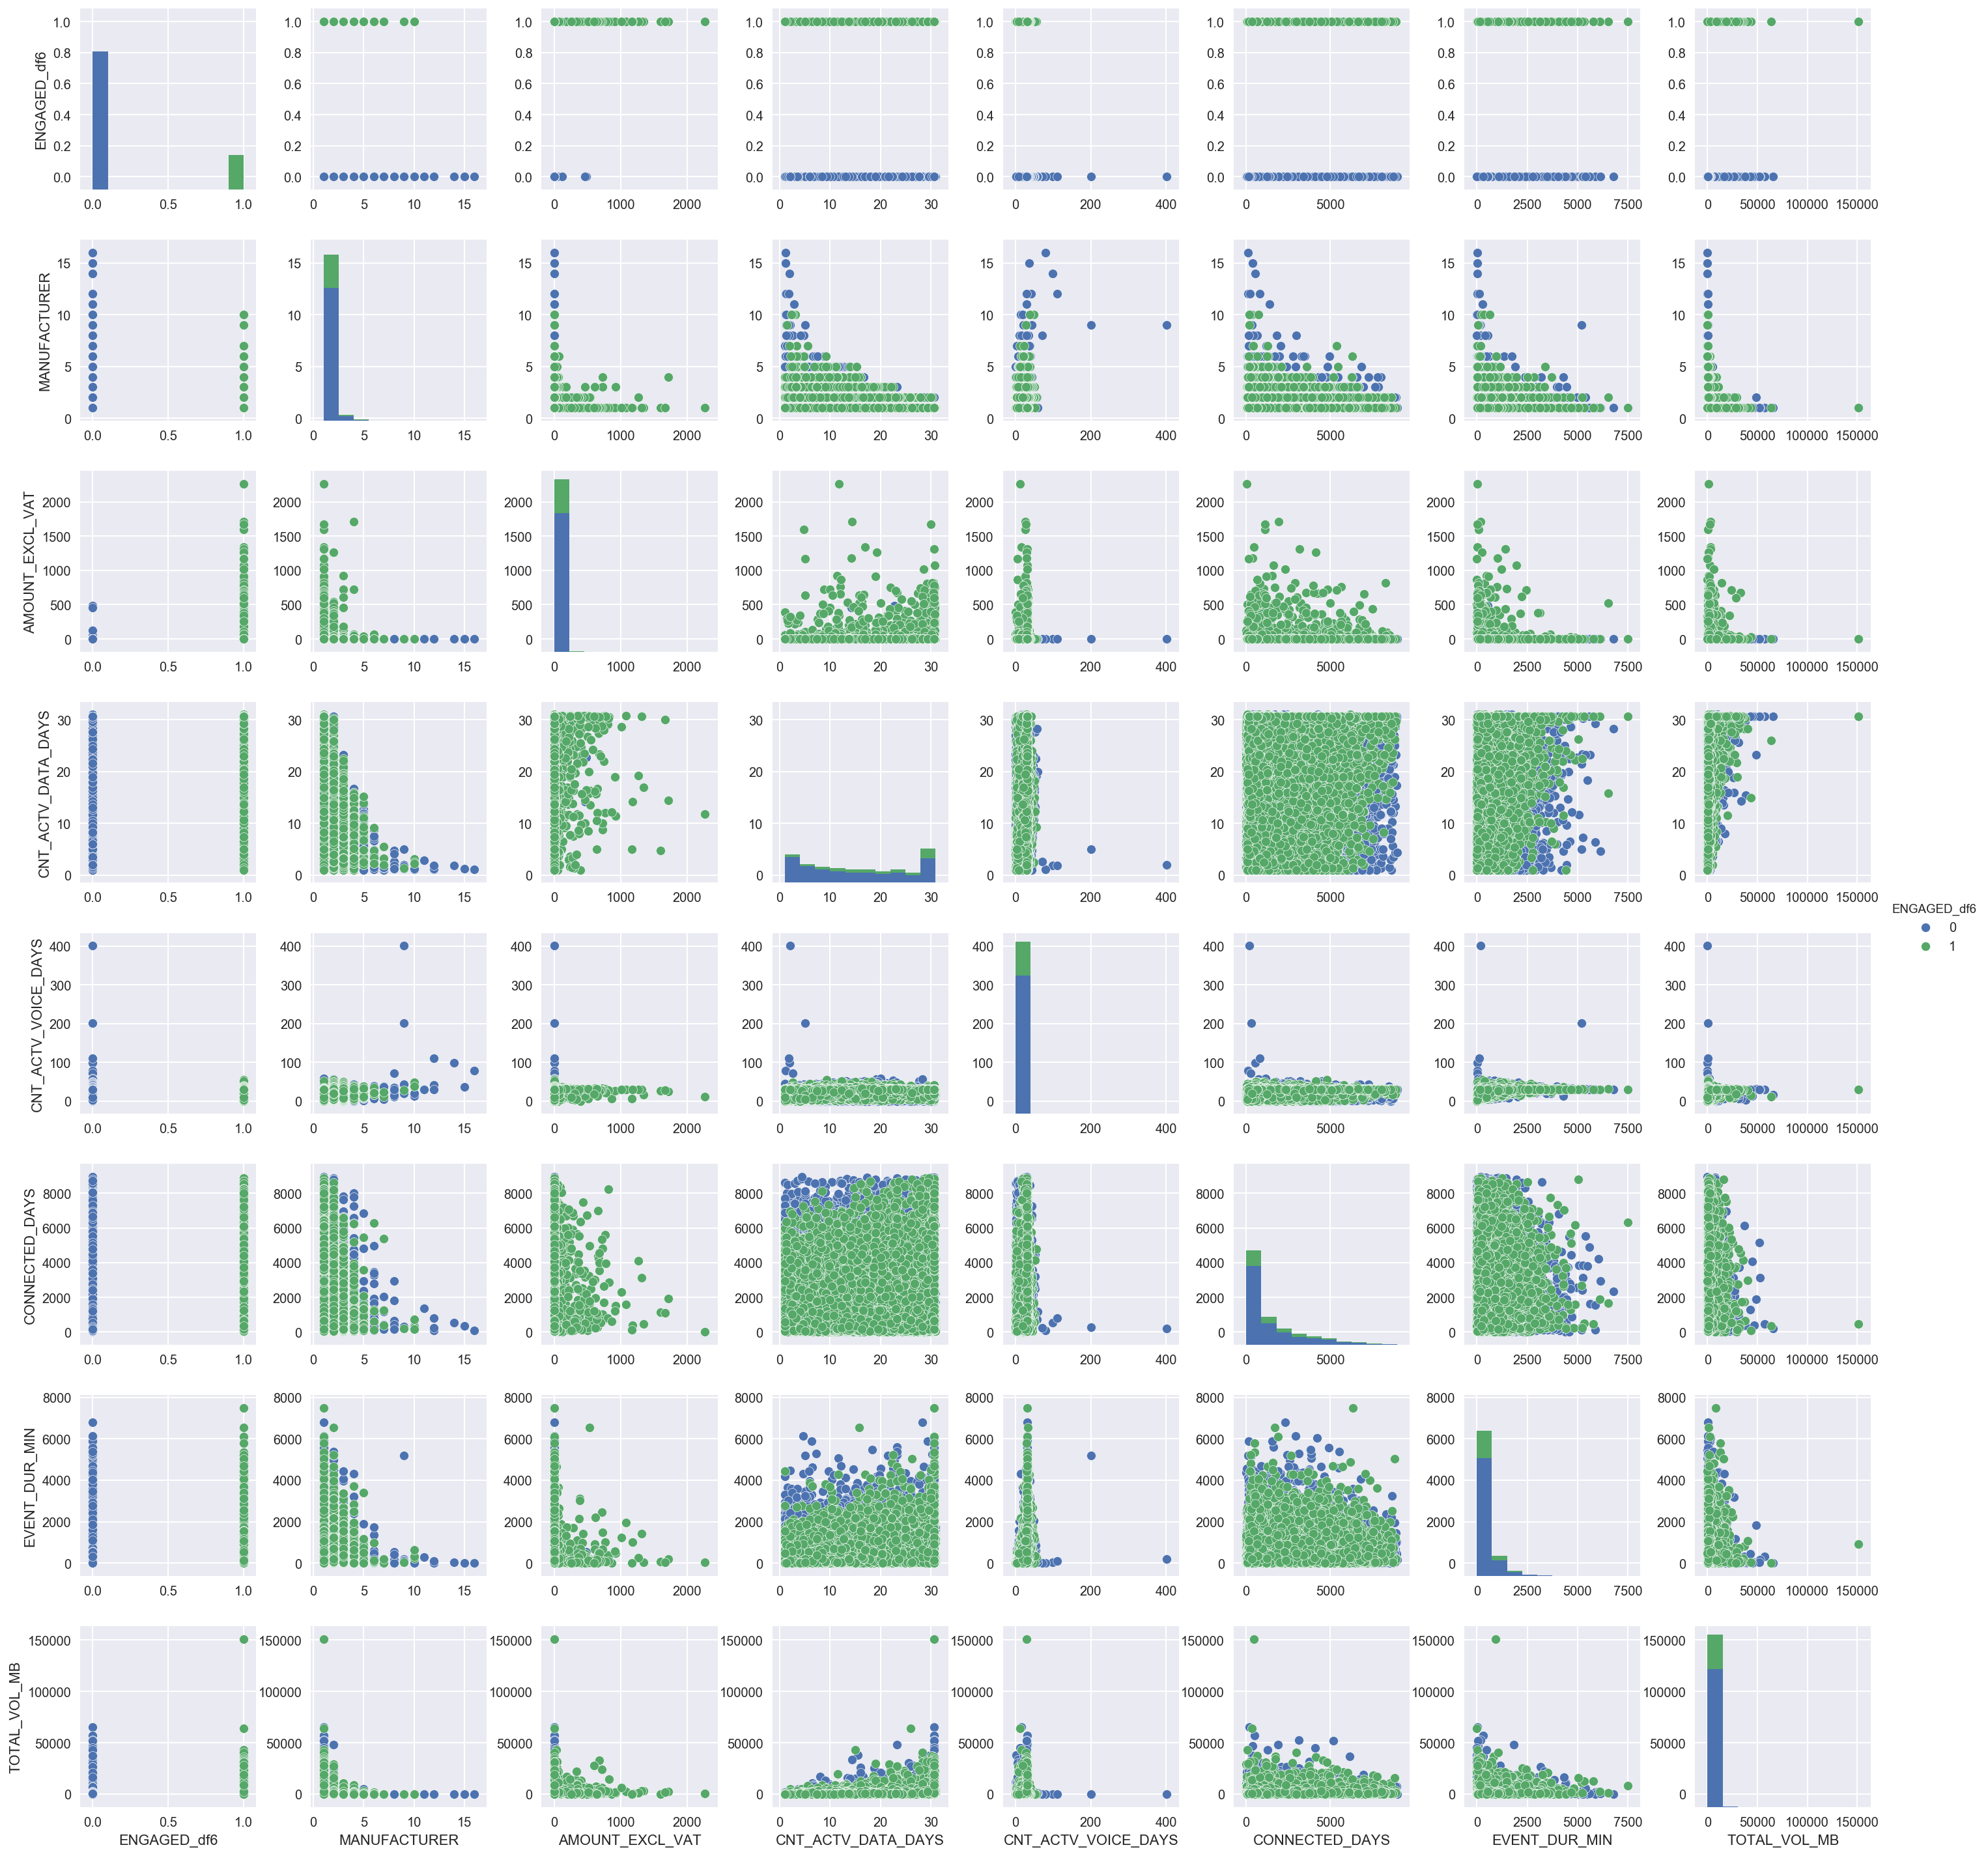

In [426]:
sns.pairplot(data=df7,hue='ENGAGED_df6')

In [746]:
df8.corr()

,ENGAGED_df6,MANUFACTURER,AMOUNT_EXCL_VAT,CNT_ACTV_DATA_DAYS,CNT_ACTV_VOICE_DAYS,CONNECTED_DAYS,EVENT_DUR_MIN,TOTAL_VOL_MB,Data_Voice,ENGAGED
ENGAGED_df6,1.000000,0.023314,0.106349,0.170644,0.155555,0.072429,0.088925,0.170931,0.005599,0.535665
MANUFACTURER,0.023314,1.000000,-0.002272,-0.224019,-0.003245,-0.093809,-0.001934,-0.069497,-0.162933,0.053473
AMOUNT_EXCL_VAT,0.106349,-0.002272,1.000000,0.035903,0.022107,0.020908,0.003515,0.080102,0.007666,0.244652
CNT_ACTV_DATA_DAYS,0.170644,-0.224019,0.035903,1.000000,0.525375,0.249217,0.191615,0.365289,0.391299,0.120826
CNT_ACTV_VOICE_DAYS,0.155555,-0.003245,0.022107,0.525375,1.000000,0.324623,0.457607,0.177638,-0.247113,0.100974
CONNECTED_DAYS,0.072429,-0.093809,0.020908,0.249217,0.324623,1.000000,0.200755,0.110370,-0.022417,0.050386
EVENT_DUR_MIN,0.088925,-0.001934,0.003515,0.191615,0.457607,0.200755,1.000000,0.120780,-0.126657,0.020698
TOTAL_VOL_MB,0.170931,-0.069497,0.080102,0.365289,0.177638,0.110370,0.120780,1.000000,0.132401,0.160562
Data_Voice,0.005599,-0.162933,0.007666,0.391299,-0.247113,-0.022417,-0.126657,0.132401,1.000000,0.013595
ENGAGED,0.535665,0.053473,0.244652,0.120826,0.100974,0.050386,0.020698,0.160562,0.013595,1.000000


#### MODEL

In [747]:
y = df8['ENGAGED_df6']
X = df8.drop(['ENGAGED_df6'], axis=1)
X.drop("MSISDN",axis=1,inplace = True)
#X.drop("AMOUNT_EXCL_VAT",axis=1,inplace = True)
# y = data_cp['Churn'].values
# X = data_transformed.values

In [748]:
X.head()

,MANUFACTURER,AMOUNT_EXCL_VAT,CNT_ACTV_DATA_DAYS,CNT_ACTV_VOICE_DAYS,CONNECTED_DAYS,EVENT_DUR_MIN,TOTAL_VOL_MB,Data_Voice,ENGAGED
0,3,0.000,10.428571,27.142857,159.0,425.762857,1041.457016,0.370558,5
1,2,5.196,11.900000,29.000000,1231.0,193.360000,2238.849556,0.396667,6
2,1,0.000,1.000000,3.000000,388.0,0.625000,0.018265,0.250000,0
3,1,0.000,29.666667,28.333333,135.0,167.436667,3345.121590,1.011364,0
4,1,0.000,16.166667,30.333333,3055.0,106.248333,1963.054527,0.515957,0


In [749]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
  train_test_split(X, y, test_size=0.25, random_state=123)

In [750]:
from sklearn.linear_model import LogisticRegression

In [751]:
logmodel = LogisticRegression()

In [752]:
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [753]:
predictions = logmodel.predict(X_test)

In [754]:
from sklearn.metrics import classification_report, confusion_matrix

In [790]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.87      0.98      0.92     16473
          1       0.85      0.42      0.56      4290

avg / total       0.86      0.86      0.85     20763



In [ ]:
confusion_matrix(data['admit'], data['pred'])
# array([[175,  98],
#        [ 46,  81]])

In [756]:
predictions_probability = logmodel.predict_proba(X_test)

In [757]:
y =pd.DataFrame(y_test)

In [758]:
predictions_probability[:,:0]

array([], shape=(20763, 0), dtype=float64)

In [817]:
y["prob"]= predictions_probability[:,1]

In [824]:
y['prob_d'] = np.where(y['prob']<=0.2, 0, 1)

In [825]:
pd.crosstab(y.prob_d, y.ENGAGED_df6, margins=True)

ENGAGED_df6,0,1,All
prob_d,,,
0,15418,1999,17417
1,1055,2291,3346
All,16473,4290,20763


In [826]:
print(classification_report(y['ENGAGED_df6'], y['prob_d']))

             precision    recall  f1-score   support

          0       0.89      0.94      0.91     16473
          1       0.68      0.53      0.60      4290

avg / total       0.84      0.85      0.85     20763



In [827]:
from sklearn.metrics import roc_curve, auc

In [828]:
fpr, tpr, threshold = roc_curve(y_test, predictions)

In [829]:
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

Area under the ROC curve : 0.698400


             precision    recall  f1-score   support

          0       0.88      0.97      0.92     16473
          1       0.80      0.48      0.60      4290

avg / total       0.86      0.87      0.86     20763



In [783]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.ix[(roc.tf-0).abs().argsort()[:1]]

# Plot tpr vs 1-fpr
fig, ax = pl.subplots()
pl.plot(roc['tpr'])
pl.plot(roc['1-fpr'], color = 'red')
pl.xlabel('1-False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
ax.set_xticklabels([])

ValueError: Wrong number of items passed 2, placement implies 3

In [788]:
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(y_test, predictions)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 




In [789]:
threshold = Find_Optimal_Cutoff(y['ENGAGED_df6'], y['prob'])
print (threshold)

[1]


/Users/dgitahi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [ ]:

# Find optimal probability threshold
threshold = Find_Optimal_Cutoff(y['ENGAGED_df6'], y['prob'])
print threshold
# [0.31762762459360921]

# Find prediction to the dataframe applying threshold
data['pred'] = data['pred_proba'].map(lambda x: 1 if x > threshold else 0)

# Print confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(data['admit'], data['pred'])
# array([[175,  98],
#        [ 46,  81]])

In [785]:
y[]

,ENGAGED_df6,prob,prob_d
48721,0,0.739806,1
50079,0,0.074220,0
35096,1,0.818582,1
33774,0,0.170530,0
5884,0,0.091823,0
6348,0,0.177974,0
850,0,0.116620,0
19059,0,0.124357,0
35631,0,0.175626,0
30402,0,0.088090,0
